# House Prices: Обучение линейной регрессии, изучения эффективности методов, разновидностей линеаризации

## 1. Загрузка и анализ начальных данных

### Загрузка модулей

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

### Загрузка начальных данных

In [2]:
import yaml

with open('C:/Users/Zver/Desktop/uni/AIF/hw/config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

In [3]:
train_data = pd.read_csv(cfg['house_pricing']['train_dataset'])
test_data = pd.read_csv(cfg['house_pricing']['test_dataset'])

In [4]:
initial_test_data = test_data.copy()

### Начальный анализ

In [5]:
print("Тренировочный датасет:")
train_data.info()

Тренировочный датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    959 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          71 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null 

In [6]:
print("\nТестовый датасет:")
test_data.info()


Тестовый датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             292 non-null    int64  
 1   MSSubClass     292 non-null    int64  
 2   MSZoning       292 non-null    object 
 3   LotFrontage    242 non-null    float64
 4   LotArea        292 non-null    int64  
 5   Street         292 non-null    object 
 6   Alley          20 non-null     object 
 7   LotShape       292 non-null    object 
 8   LandContour    292 non-null    object 
 9   Utilities      292 non-null    object 
 10  LotConfig      292 non-null    object 
 11  LandSlope      292 non-null    object 
 12  Neighborhood   292 non-null    object 
 13  Condition1     292 non-null    object 
 14  Condition2     292 non-null    object 
 15  BldgType       292 non-null    object 
 16  HouseStyle     292 non-null    object 
 17  OverallQual    292 non-null    int6

## Анализ столбцов

### Распределение искомой переменной в тренировочном датасете

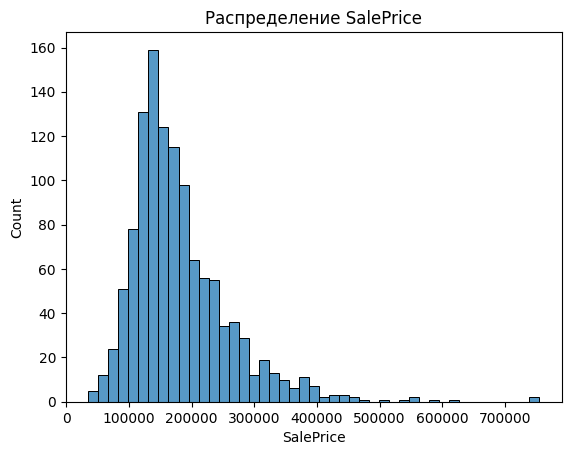

In [7]:
sns.histplot(train_data['SalePrice'])
plt.title('Распределение SalePrice')
plt.show()

### Поиск взаимозависимых переменных

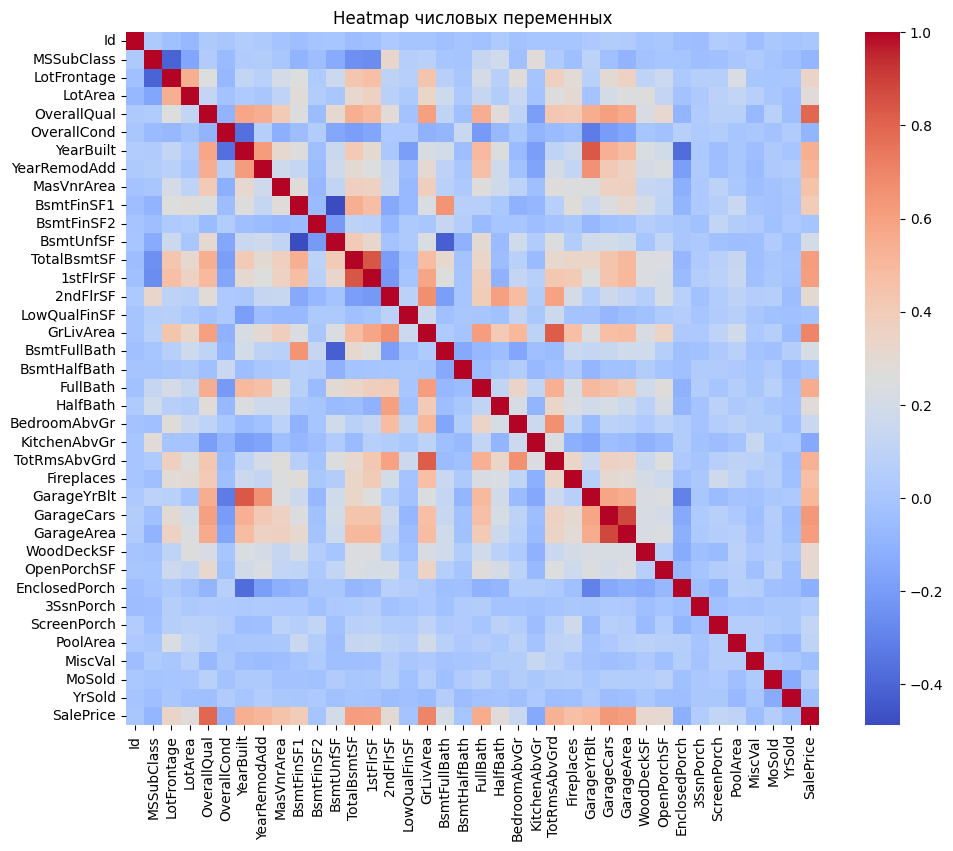

In [8]:
num_col = train_data.select_dtypes(include=['number'])
plt.figure(figsize=(12, 9))
sns.heatmap(num_col.corr(), vmax=1, square=True, cmap="coolwarm", annot=False)
plt.title("Heatmap числовых переменных")
plt.show()

Заметим, что переменная OverallQual сильно связана с целевой SalePrice. Поэтому для улучшения точности модели нужно избавиться от статистических выбросов в этом столбце.

### Удаление выбросов

Удаленные ID строк для OverallQual: [41, 44, 106, 124, 359, 443, 519, 559, 570, 858, 863, 913, 969, 1031, 1115]


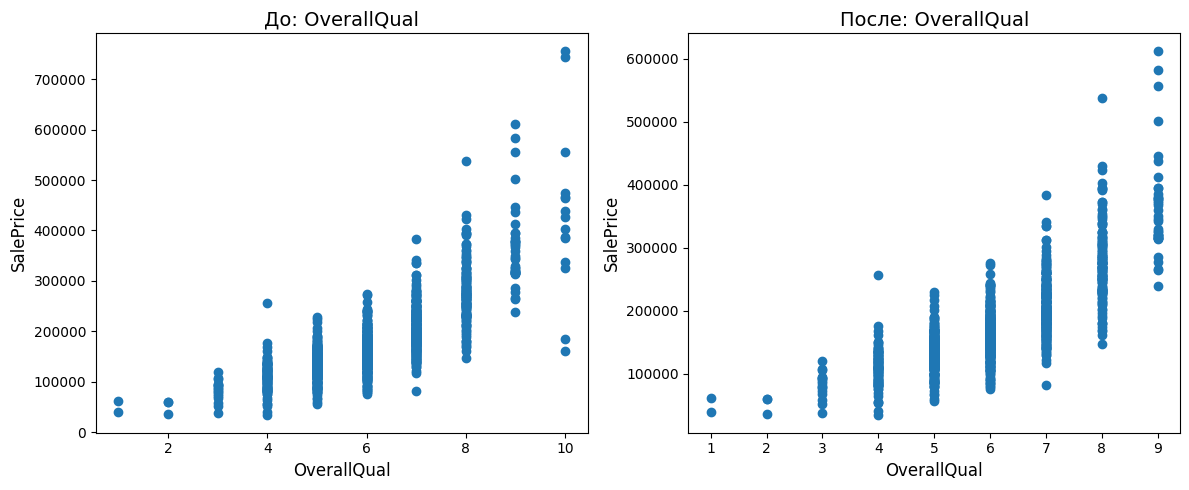

In [9]:
corr = ["OverallQual"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5 * len(corr)))
del_coeff = 0.999

for i, ft in enumerate(corr):
    axes[0].scatter(x=train_data[ft], y=train_data['SalePrice'])
    axes[0].set_title(f'До: {ft}', fontsize=14)
    axes[0].set_xlabel(ft, fontsize=12)
    axes[0].set_ylabel('SalePrice', fontsize=12)

    outliers = train_data[train_data[ft] >= train_data[ft].quantile(del_coeff)].index
    print(f"Удаленные ID строк для {ft}: {list(outliers)}")

    filtered = train_data.drop(outliers)

    axes[1].scatter(x=filtered[ft], y=filtered['SalePrice'])
    axes[1].set_title(f'После: {ft}', fontsize=14)
    axes[1].set_xlabel(ft, fontsize=12)
    axes[1].set_ylabel('SalePrice', fontsize=12)

plt.tight_layout()
plt.show()

train_data = filtered

### Проверка размеров датасета

In [10]:
print(train_data.shape)

(1153, 81)


In [11]:
X_train_full = train_data.drop('SalePrice', axis=1)
y_train = train_data['SalePrice']
X_test = test_data.copy()

### Разделение на числовые и категориальные переменные

In [12]:
numerical_features = X_train_full.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train_full.select_dtypes(include='object').columns.tolist()

### Функция, применяющая указанный метод энкодинга к датасету (OneHot, Label или Frequency)

In [13]:
def apply_encoding(train, test, encoding_method, target_column='SalePrice', features_to_encode=None):
    """
    Применяет указанный метод энкодинга.
    """
    train = train.copy()
    test = test.copy()
            
    if features_to_encode is None:
        categorical_features = train.select_dtypes(include='object').columns.tolist()
        features_to_encode = categorical_features
    else:
        features_to_encode = [col for col in features_to_encode if col in train.columns and col in test.columns]

    if encoding_method == "onehot":
        train = pd.get_dummies(train, columns=features_to_encode, dummy_na=False)
        test = pd.get_dummies(test, columns=features_to_encode, dummy_na=False)
        train_cols = set(train.columns)
        test_cols = set(test.columns)
        missing_in_test = train_cols - test_cols
        for c in missing_in_test:
            test[c] = 0
        missing_in_train = test_cols - train_cols
        for c in missing_in_train:
            train[c] = 0
        test = test[train.columns.drop(target_column, errors='ignore')]
        test = test.reindex(columns=train.columns.drop(target_column, errors='ignore'), fill_value=0)

    elif encoding_method == "label":
        for col in features_to_encode:
            le = LabelEncoder()
            combined_data = pd.concat([train[col], test[col]], axis=0).astype(str)
            le.fit(combined_data)
            train[col] = le.transform(train[col].astype(str))
            test[col] = le.transform(test[col].astype(str))

    elif encoding_method == "frequency":
        for col in features_to_encode:
            frequencies = train[col].value_counts(normalize=True)
            train[col] = train[col].map(frequencies)
            test[col] = test[col].map(frequencies)

    return train, test

### Применение энкодинга, логарифмического преобразования, SimpleImputer, StandardScaler

In [14]:
from sklearn.metrics import r2_score, mean_squared_log_error

def msle(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred)
    
encoding_method = "onehot"  # Или "label", "frequency"
print(f"Running experiment with encoding method: {encoding_method}")

train_data['SalePrice'] = np.log1p(train_data['SalePrice'])
train_data, test_data = apply_encoding(train_data, test_data, encoding_method=encoding_method, features_to_encode=categorical_features)

X = train_data.drop(['SalePrice', 'Id'], axis=1)
y = train_data['SalePrice']

test_data = test_data.drop(['Id'], axis=1, errors='ignore')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.205, random_state=42)

missing_cols = set(X_train.columns) - set(test_data.columns)
for c in missing_cols:
    test_data[c] = 0

missing_cols = set(test_data.columns) - set(X_train.columns)
for c in missing_cols:
    X_train[c] = 0

test_data = test_data[X_train.columns]

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
test_data = imputer.transform(test_data)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test_data = scaler.transform(test_data)

Running experiment with encoding method: onehot


### Применение регрессии и линеаризации

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

def msle(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred)

# --- Параметры поиска ---

param_grid_lasso = {'alpha': [0.01]}
param_grid_elastic = {'alpha': [0.0049, 0.005, 0.0051], 'l1_ratio': [0.99, 1]}

# --- Обучение модели ---

# Линейная регрессия
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_val)
msle_lr = msle(np.expm1(y_val), np.expm1(y_pred_lr))
print("Unregularized Linear Regression:")
print(f"MSLE: {msle_lr:.5f}")

# Линейная регрессия + L1
grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, scoring='neg_mean_squared_log_error', cv=5, n_jobs=-1)
grid_search_lasso.fit(X_train, y_train)
model_lasso = grid_search_lasso.best_estimator_
y_pred_lasso = model_lasso.predict(X_val)
msle_lasso = msle(np.expm1(y_val), np.expm1(y_pred_lasso))
print("\nLasso (L1) Regression:")
print(f"Best parameters: {grid_search_lasso.best_params_}")
print(f"MSLE: {msle_lasso:.5f}")

# Линейная регрессия + ElasticNet
grid_search_elastic = GridSearchCV(ElasticNet(), param_grid_elastic, scoring='neg_mean_squared_log_error', cv=5, n_jobs=-1)
grid_search_elastic.fit(X_train, y_train)
model_elastic = grid_search_elastic.best_estimator_
y_pred_elastic = model_elastic.predict(X_val)
msle_elastic = msle(np.expm1(y_val), np.expm1(y_pred_elastic))
print("\nElastic Net Regression:")
print(f"Best parameters: {grid_search_elastic.best_params_}")
print(f"MSLE: {msle_elastic:.5f}")

# --- Предсказания и генерация итогового файла ---
X_test = test_data
predictions = model_elastic.predict(X_test) # <--- Изменить модель если нужно

predictions = np.expm1(predictions)
predictions[predictions < 0] = 0

submission = pd.DataFrame({'Id': initial_test_data['Id'], 'SalePrice': predictions})
submission['SalePrice'] = submission['SalePrice'].round(0).astype(int)

submission.to_csv("submission.csv", index=False)
print("Submission file created successfully!")

Unregularized Linear Regression:
MSLE: 0.02089

Lasso (L1) Regression:
Best parameters: {'alpha': 0.01}
MSLE: 0.01897

Elastic Net Regression:
Best parameters: {'alpha': 0.005, 'l1_ratio': 1}
MSLE: 0.01757
Submission file created successfully!


## Сравнение комбинаций

Сравним эффективность различных комбинаций энкодингов и линеаризаций
За референсные значение возьмем Alpha = 0.01 и L1_Ratio = 0.7, используется оценка MSLE

In [16]:
import pandas as pd

def create_nxm_table(n, m, column_names=None, index_names=None, data=None):
  """
  Creates a Pandas DataFrame representing an n x m table, ready for display in a Jupyter Notebook.

  Args:
    n (int): The number of rows.
    m (int): The number of columns.
    column_names (list of str, optional):  A list of column names of length m.  If None, default column names are used.
    index_names (list of str, optional): A list of index (row) names of length n. If None, default integer index is used.
    data (list of list, optional): A list of lists, where each inner list is a row of data (length m).
                                     If None, the table is filled with placeholder "Value (row, col)" strings.  If
                                     provided, the dimensions *must* match n x m.

  Returns:
    pd.DataFrame: A Pandas DataFrame representing the table.
  """

  if column_names is not None and len(column_names) != m:
    raise ValueError(f"Number of column names ({len(column_names)}) must match the number of columns ({m}).")

  if index_names is not None and len(index_names) != n:
    raise ValueError(f"Number of index names ({len(index_names)}) must match the number of rows ({n}).")

  if data is not None:
    if len(data) != n:
        raise ValueError(f"Number of rows in data ({len(data)}) must match n ({n}).")
    for row in data:
        if len(row) != m:
            raise ValueError(f"Number of columns in data rows must match m ({m})")


  # Create default column names if none are provided
  if column_names is None:
    column_names = [f"Column {i+1}" for i in range(m)]

  # Create default data if none is provided
  if data is None:
      data = [ [f"Value ({row+1}, {col+1})" for col in range(m)] for row in range(n) ]


  # Create the DataFrame
  df = pd.DataFrame(data, columns=column_names)

  # Set the index names if provided
  if index_names is not None:
    df.index = index_names

  return df

# --- Example Usage ---

# Example 3: 4x3 table with custom data
column_names = ["Encoding", "Linear", "Lasso", "ElasticNet"]
#index_names = [f"Person {i+1}" for i in range(3)]
data = [
    ["OneHot", 0.02089, 0.01897, 0.01802],
    ["Label", 0.01991, 0.02142, 0.02085],
    ["Frequency", 0.02002, 0.02188, 0.02133]
]
table3 = create_nxm_table(3, 4, column_names=column_names, data=data)
display(table3)

,Encoding,Linear,Lasso,ElasticNet
0,OneHot,0.02089,0.01897,0.01802
1,Label,0.01991,0.02142,0.02085
2,Frequency,0.02002,0.02188,0.02133


Заметим, что лучшей комбинацией является OneHot + ElasticNet, попробуем оптимизировать параметры линеаризации для получения наивысшего результата MSLE. Для этого используем GridSearchCV. Попробуем найти лучшую комбинацию alpha и l1_ratio для OneHot+ElasticNet с точностью до 0.xxxx и 0.xx соответственно.

Поиск alpha:
1) Варианты: 0.0001, 0.001, 0.01, 0.1; Результат: 0.01
2) Варианты: 0.005, 0.01, 0.015; Результат: 0.005
3) Варианты: 0.003, 0.005, 0.007; Результат: 0.005
4) Варианты: 0.0045, 0.005, 0.0055; Результат: 0.005
5) Варианты: 0.0049, 0.005, 0.0051; Результат: 0.005

Итого: alpha = 0.005

Поиск l1_ratio:
1) Варианты: 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1; Результат: 1
2) Варианты: 0.95, 1; Результат: 1
3) Варианты: 0.99, 1; Результат: 1

Итого: l1_ratio = 1

Таким образом, лучший результат достигается при использовании OneHot+ElasticNet при alpha = 0.005 и l1_ratio = 1; MSLE = 0.01757